# **Activity 3: Mechanical properties of PHA polymers for Medical Sutures**

Before you proceed this workflow, I encourage you to follow the tutorials on ```00_tutorials/``` folder prior programming to have everything downloaded.

To proceed this workflow, you will also have been executed the previous workflow: ```01_docking_human_proteins.ipynb```.

Make sure you already have installed ```pandas```, ```matplotlib```, ```rdkit```, ```numpy```, ```scipy``` libraries. Otherwise, copy the following lines and paste it on the terminal:

1. ```conda activate vina```
2. ```conda install pandas matplotlib rdkit numpy scipy```

## **1. Import libraries**

In [1]:
# Library for chemical manipulation
from rdkit import Chem
from rdkit.Chem import AllChem, Descriptors, rdMolDescriptors, Descriptors3D, Crippen, rdChemReactions
# Library for numerical manipulation and statistical analysis
import numpy as np
from scipy.stats import linregress
# Library for DataFrame Manipulation
import pandas as pd
# Library for plotting
import matplotlib.pyplot as plt
# Library for warning handling
import warnings
warnings.filterwarnings('ignore')

## **2. Define Custom Functions**

In [2]:
def build_oligomer(monomer_smiles, rxn_smarts, n_units):
    """Build polymer oligomer from monomer units"""
    monomer = Chem.MolFromSmiles(monomer_smiles)
    if n_units == 1:
        mol = Chem.AddHs(monomer)
        AllChem.EmbedMolecule(mol, AllChem.ETKDG())
        AllChem.MMFFOptimizeMolecule(mol)
        return mol
        
    rxn = rdChemReactions.ReactionFromSmarts(rxn_smarts)
    polymer = Chem.AddHs(monomer)
    for _ in range(n_units - 1):
        products = rxn.RunReactants((polymer, Chem.AddHs(monomer)))
        if products:
            polymer = products[0][0]
            Chem.SanitizeMol(polymer)
            
    polymer_3d = Chem.AddHs(polymer)
    AllChem.EmbedMolecule(polymer_3d, AllChem.ETKDGv3())
    AllChem.MMFFOptimizeMolecule(polymer_3d)
    return polymer_3d

def get_end_to_end_distance(mol):
    """Calculate end-to-end distance for chain analysis"""
    try:
        conf = mol.GetConformer()
        # Get first and last heavy atom positions
        positions = []
        for atom in mol.GetAtoms():
            if atom.GetAtomicNum() > 1:  # Skip hydrogens
                pos = conf.GetAtomPosition(atom.GetIdx())
                positions.append(pos)
        
        if len(positions) >= 2:
            start = positions[0]
            end = positions[-1]
            distance = np.sqrt((end.x - start.x)**2 + (end.y - start.y)**2 + (end.z - start.z)**2)
            return distance
        return 0
    except:
        return 0

In [3]:
def get_comprehensive_stats(mol, n, monomer_length=3.5):
    """Calculate comprehensive polymer properties"""
    ester_pattern = Chem.MolFromSmarts('[C](=O)O[C]')
    methyl_pattern = Chem.MolFromSmarts('[CH3]')
    
    mw = Descriptors.MolWt(mol)
    rg = Descriptors3D.RadiusOfGyration(mol)
    r_ee = get_end_to_end_distance(mol)
    esters = len(mol.GetSubstructMatches(ester_pattern))
    methyls = len(mol.GetSubstructMatches(methyl_pattern))
    
    # Calculate additional metrics
    heavy_atoms = Descriptors.HeavyAtomCount(mol)
    rotatable = Descriptors.NumRotatableBonds(mol)
    sasa = rdMolDescriptors.CalcLabuteASA(mol)
    
    # Contour length estimate
    contour_length = n * monomer_length
    
    # Chain flexibility metrics
    flexibility_ratio = rotatable / heavy_atoms if heavy_atoms > 0 else 0
    shape_ratio = (r_ee / rg) if rg > 0 else 0
    
    # Persistence length estimate (crude approximation)
    persistence_length = (rg**2 / contour_length) if contour_length > 0 else 0
    
    return {
        "n": n,
        "MW": round(mw, 2),
        "LogP": round(Crippen.MolLogP(mol), 2),
        "TPSA": round(Descriptors.TPSA(mol), 2),
        "Asphericity": round(rdMolDescriptors.CalcAsphericity(mol), 3),
        "Rg": round(rg, 2),
        "R_ee": round(r_ee, 2),
        "Shape_Ratio": round(shape_ratio, 2),
        "Ester_Count": esters,
        "Ester_Density": round((esters / mw) * 1000, 2),
        "Rotatable_Bonds": rotatable,
        "Flexibility": round(flexibility_ratio, 3),
        "SASA": round(sasa, 2),
        "Persistence_Length": round(persistence_length, 2),
        "Methyl_Branches": methyls
    }

def plot_polymer_scaling(polymers_dict, polymer_names=None, figsize=(12, 8), filename=None):
    """
    Plot scaling results for one or multiple polymers.
    """

    if polymer_names is None:
        polymer_names = list(polymers_dict.keys())
    
    # Create figure with subplots
    fig, axes = plt.subplots(2, 2, figsize=figsize)
    
    # Define colors for different polymers
    colors = ['blue', 'green', 'red', 'purple', 'orange', 'brown', 'pink', 'gray']
    
    for idx, polymer_name in enumerate(polymer_names):
        df = polymers_dict[polymer_name]
        color = colors[idx % len(colors)]
        
        # Plot 1: Radius of Gyration
        axes[0, 0].plot(df['n'], df['Rg'], 'o-', color=color, label=polymer_name, alpha=0.7)
        axes[0, 0].set_xlabel('Oligomer Size (n)')
        axes[0, 0].set_ylabel('Rg (Å)')
        axes[0, 0].set_title('Radius of Gyration (Rg)')
        axes[0, 0].grid(True, alpha=0.3)
        
        # Plot 2: Asphericity
        axes[0, 1].plot(df['n'], df['Asphericity'], 's-', color=color, label=polymer_name, alpha=0.7)
        axes[0, 1].set_xlabel('Oligomer Size (n)')
        axes[0, 1].set_ylabel('Asphericity')
        axes[0, 1].set_title('Asphericity (Linearity)')
        axes[0, 1].grid(True, alpha=0.3)
        
        # Plot 3: LogP
        axes[1, 0].plot(df['n'], df['LogP'], '^-', color=color, label=polymer_name, alpha=0.7)
        axes[1, 0].set_xlabel('Oligomer Size (n)')
        axes[1, 0].set_ylabel('LogP')
        axes[1, 0].set_title('LogP (Hydrophobicity)')
        axes[1, 0].grid(True, alpha=0.3)
        
        # Plot 4: Ester Density
        axes[1, 1].plot(df['n'], df['Ester_Density'], 'D-', color=color, label=polymer_name, alpha=0.7)
        axes[1, 1].set_xlabel('Oligomer Size (n)')
        axes[1, 1].set_ylabel('Ester Density')
        axes[1, 1].set_title('Ester Density (Degradability)')
        axes[1, 1].grid(True, alpha=0.3)
    
    # Add legends
    if len(polymer_names) > 1:
        for ax in axes.flat:
            ax.legend(loc='best', fontsize=9)
    
    plt.tight_layout()
    
    # Save plot if filename is provided
    if filename:
        plt.savefig(filename, dpi=300, bbox_inches='tight')
        print(f"Plot saved to {filename}")
    
    plt.show()

## **3. Create Dictionary to store polymers data**

In [4]:
polymers_dict = {} # key ("polymer_name") : value (DataFrame)

## **4. Build PHB oligomers and calculate properties**

In [5]:
print("Building PHB oligomers...")
phb_smiles = "C[C@H](CC(=O)O)O"
phb_rxn = '[C:1](=[O:2])[O:5][H].[C:3][O:4][H:6]>>[C:1](=[O:2])[O:4][C:3].[O:5][H][H:6]'

phb_results = []
for i in range(1, 13):
    mol = build_oligomer(phb_smiles, phb_rxn, i)
    stats = get_comprehensive_stats(mol, i)
    phb_results.append(stats)
    print(f"\t-Completed {i}-mer")

# Convert information as a DataFrame
phb_df = pd.DataFrame(phb_results)

# Store data in Dictionary
polymers_dict["PHB"] = phb_df

# Print results
print("\nPHB Analysis Complete")
print(phb_df)

# Store DataFrame
phb_df.to_csv('output/mechanical_prop/phb_oligomers.csv', index=False)

Building PHB oligomers...
	-Completed 1-mer
	-Completed 2-mer
	-Completed 3-mer
	-Completed 4-mer
	-Completed 5-mer
	-Completed 6-mer
	-Completed 7-mer
	-Completed 8-mer
	-Completed 9-mer
	-Completed 10-mer
	-Completed 11-mer
	-Completed 12-mer

PHB Analysis Complete
     n       MW  LogP    TPSA  Asphericity     Rg  R_ee  Shape_Ratio  \
0    1   104.10 -0.16   57.53        0.359   1.93  2.40         1.24   
1    2   190.19  0.16   83.83        0.607   3.14  5.27         1.68   
2    3   276.29  0.49  110.13        0.589   4.21  5.93         1.41   
3    4   362.37  0.81  136.43        0.759   5.02  5.21         1.04   
4    5   448.46  1.13  162.73        0.472   5.50  5.95         1.08   
5    6   534.56  1.45  189.03        0.592   6.55  4.29         0.65   
6    7   620.65  1.77  215.33        0.870   8.99  5.24         0.58   
7    8   706.74  2.09  241.63        0.735   8.66  5.33         0.62   
8    9   792.83  2.42  267.93        0.796  10.12  5.31         0.53   
9   10   878

Plot saved to output/mechanical_prop/phb_mechanical_properties.svg


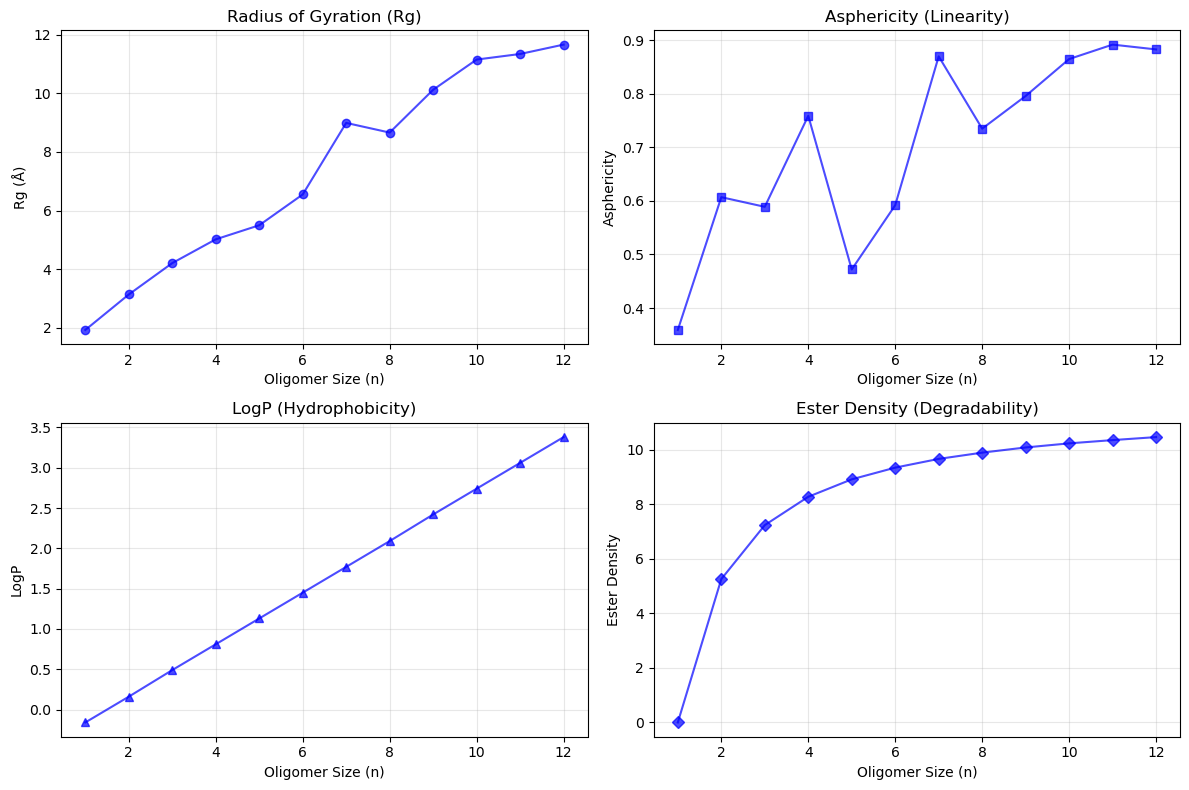

In [6]:
# Plot a single polymer
plot_polymer_scaling(
    polymers_dict,
    polymer_names=["PHB"],
    filename="output/mechanical_prop/phb_mechanical_properties.svg"
)

## **5. Build PGA Oligomers for Comparison (Standard for Medical Sutures)**

In [7]:
print("\nBuilding PGA oligomers...")
pga_smiles = "C(C(=O)O)O"  # Glycolic acid
pga_rxn = '[C:1](=[O:2])[O:5][H].[C:3][O:4][H:6]>>[C:1](=[O:2])[O:4][C:3].[O:5][H][H:6]'

pga_results = []
for i in range(1, 13):
    mol = build_oligomer(pga_smiles, pga_rxn, i)
    stats = get_comprehensive_stats(mol, i, monomer_length=2.8)
    pga_results.append(stats)
    print(f"\t- Completed {i}-mer")

# Convert information as a DataFrame
pga_df = pd.DataFrame(pga_results)

# Store data in Dictionary
polymers_dict["PGA"] = pga_df

print("\nPGA Analysis Complete")
print(pga_df)

# Store DataFrame
pga_df.to_csv('output/mechanical_prop/pga_oligomers.csv', index=False)


Building PGA oligomers...
	- Completed 1-mer
	- Completed 2-mer
	- Completed 3-mer
	- Completed 4-mer
	- Completed 5-mer
	- Completed 6-mer
	- Completed 7-mer
	- Completed 8-mer
	- Completed 9-mer
	- Completed 10-mer
	- Completed 11-mer
	- Completed 12-mer

PGA Analysis Complete
     n      MW  LogP    TPSA  Asphericity    Rg  R_ee  Shape_Ratio  \
0    1   76.05 -0.94   57.53        0.398  1.52  1.42         0.94   
1    2  134.09 -1.39   83.83        0.471  2.34  3.99         1.71   
2    3  192.12 -1.85  110.13        0.626  3.00  4.20         1.40   
3    4  250.16 -2.31  136.43        0.217  2.98  3.12         1.05   
4    5  308.19 -2.76  162.73        0.686  4.81  4.71         0.98   
5    6  366.23 -3.22  189.03        0.587  5.09  4.21         0.83   
6    7  424.27 -3.68  215.33        0.712  5.94  4.71         0.79   
7    8  482.30 -4.13  241.63        0.855  7.04  4.21         0.60   
8    9  540.34 -4.59  267.93        0.680  6.08  3.95         0.65   
9   10  598.38 -5.0

Plot saved to output/mechanical_prop/pga_mechanical_properties.svg


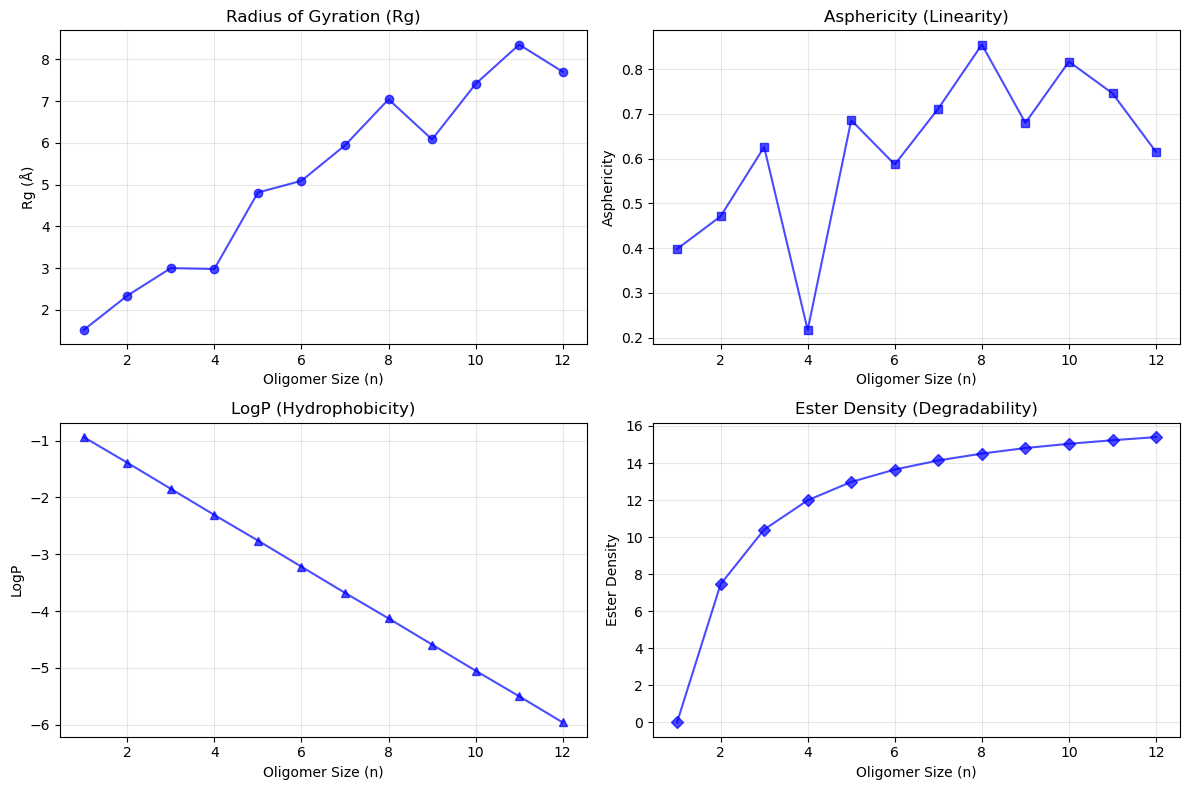

In [8]:
# Plot a single polymer
plot_polymer_scaling(
    polymers_dict,
    polymer_names=["PGA"],
    filename="output/mechanical_prop/pga_mechanical_properties.svg"
)

## **6. Build PLLA Oligomers for Comparison (Biopolymer)**

In [9]:
print("\nBuilding PLLA oligomers...")

plla_smiles = "C[C@H](C(=O)O)O"  # L-Lactic acid
plla_rxn = '[C:1](=[O:2])[O:5][H].[C:3][O:4][H:6]>>[C:1](=[O:2])[O:4][C:3].[O:5][H][H:6]'

plla_results = []
for i in range(1, 13):
    mol = build_oligomer(plla_smiles, plla_rxn, i)
    stats = get_comprehensive_stats(mol, i, monomer_length=3.0)
    plla_results.append(stats)
    print(f"\t- Completed {i}-mer")

# Convert information as a DataFrame
plla_df = pd.DataFrame(plla_results)

# Store data in Dictionary
polymers_dict["PLLA"] = plla_df

# Print results
print("\nPLLA Analysis Complete")
print(plla_df)

# Store DataFrame
plla_df.to_csv('output/mechanical_prop/plla_oligomers.csv', index=False)


Building PLLA oligomers...
	- Completed 1-mer
	- Completed 2-mer
	- Completed 3-mer
	- Completed 4-mer
	- Completed 5-mer
	- Completed 6-mer
	- Completed 7-mer
	- Completed 8-mer
	- Completed 9-mer
	- Completed 10-mer
	- Completed 11-mer
	- Completed 12-mer

PLLA Analysis Complete
     n      MW  LogP    TPSA  Asphericity    Rg  R_ee  Shape_Ratio  \
0    1   90.08 -0.55   57.53        0.238  1.65  2.38         1.45   
1    2  162.14 -0.62   83.83        0.459  2.53  4.71         1.86   
2    3  234.20 -0.68  110.13        0.225  2.85  3.08         1.08   
3    4  306.27 -0.75  136.43        0.617  3.99  4.17         1.05   
4    5  378.33 -0.82  162.73        0.583  4.46  4.17         0.94   
5    6  450.39 -0.89  189.03        0.365  4.75  4.18         0.88   
6    7  522.46 -0.96  215.33        0.802  6.76  3.03         0.45   
7    8  594.52 -1.03  241.63        0.629  6.23  3.04         0.49   
8    9  666.58 -1.09  267.93        0.802  7.64  4.17         0.55   
9   10  738.65 -1

Plot saved to output/mechanical_prop/plla_mechanical_properties.svg


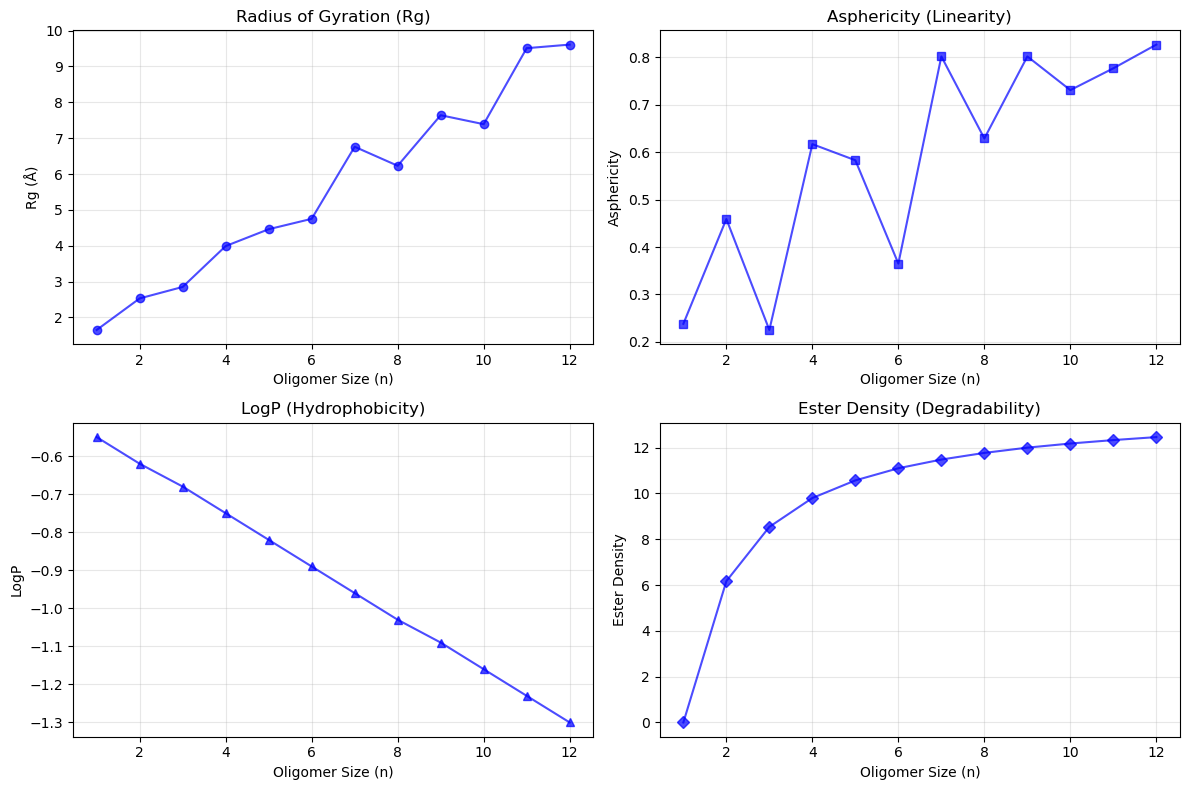

In [10]:
# Plot a single polymer
plot_polymer_scaling(
    polymers_dict,
    polymer_names=["PLLA"],
    filename="output/mechanical_prop/plla_mechanical_properties.svg"
)

## **7. Build Polystyrene Oligomers for Comparison (Negative Control)**

In [11]:
print("\nBuilding Polystyrene (Negative control of medical sutures)...")

def build_poly_oligomer(monomer_smiles, rxn_smarts, n_units):
    # 1. Setup Monomer and Reaction
    monomer = Chem.MolFromSmiles("C=Cc1ccccc1")
    rxn = AllChem.ReactionFromSmarts(rxn_smarts)
    
    # 2. Create the "Seed" (Styrene monomer with a [3H] active site)
    # We turn the double bond into a single bond with the isotope marker
    seed = Chem.MolFromSmiles("CC([3H])c1ccccc1")
    polymer = seed

    # 3. Iterative Growth
    if n_units > 1:
        for _ in range(n_units - 1):
            products = rxn.RunReactants((polymer, monomer))
            if products:
                polymer = products[0][0]
                # Sanitize to keep the aromatic ring and valency correct
                Chem.SanitizeMol(polymer)
            else:
                break

    # 4. Final Cleanup: Replace Tritium [3H] with standard Hydrogen [H]
    # This ensures your MW stats are exactly correct for Polystyrene
    final_mol = Chem.RemoveHs(polymer) # Removes the [3H] marker
    final_mol = Chem.AddHs(final_mol)    # Adds back standard [H]
    
    # 5. 3D Embedding and Optimization
    AllChem.EmbedMolecule(final_mol, AllChem.ETKDGv3())
    AllChem.MMFFOptimizeMolecule(final_mol)
    
    return final_mol

# Use Tritium [3H] as the "Active Site" where the next monomer attaches
# This is a 1-unit polystyrene chain ready for growth
poly_smiles = "C=Cc1ccccc1" # We'll handle the seed inside the function

# The Reaction: 
# Reactant 1: Chain ending in Tritium [3H]
# Reactant 2: Styrene monomer (alkene)
# Product: Chain extended, moving the [3H] to the new end
poly_rxn = "[C:1]-[3H].[CH2:2]=[CH:3][c:4] >> [*:1][CH2:2][CH:3]([3H])[c:4]"

poly_results = []
for i in range(1, 13):
    mol = build_poly_oligomer(poly_smiles, poly_rxn, i)
    stats = get_comprehensive_stats(mol, i, monomer_length=4.2)
    poly_results.append(stats)
    print(f"\t- Completed {i}-mer")

# Convert information as a DataFrame
poly_df = pd.DataFrame(poly_results)

# Store data in Dictionary
polymers_dict["Polystyrene"] = poly_df

# Print results
print("\nPolystyrene Analysis Complete")
print(poly_df)

# Store DataFrame
poly_df.to_csv('output/mechanical_prop/polystyrene_oligomers.csv', index=False)


Building Polystyrene (Negative control of medical sutures)...
	- Completed 1-mer
	- Completed 2-mer
	- Completed 3-mer
	- Completed 4-mer
	- Completed 5-mer
	- Completed 6-mer
	- Completed 7-mer
	- Completed 8-mer
	- Completed 9-mer
	- Completed 10-mer
	- Completed 11-mer
	- Completed 12-mer

Polystyrene Analysis Complete
     n       MW   LogP  TPSA  Asphericity    Rg  R_ee  Shape_Ratio  \
0    1   108.18   2.25   0.0        0.396  2.04  3.34         1.64   
1    2   212.33   4.42   0.0        0.579  3.58  6.57         1.84   
2    3   316.48   6.60   0.0        0.357  4.26  6.58         1.54   
3    4   420.63   8.77   0.0        0.332  4.84  6.57         1.36   
4    5   524.78  10.94   0.0        0.251  5.09  6.60         1.30   
5    6   628.94  13.12   0.0        0.177  5.38  5.82         1.08   
6    7   733.09  15.29   0.0        0.322  6.15  5.41         0.88   
7    8   837.24  17.47   0.0        0.339  6.36  6.57         1.03   
8    9   941.39  19.64   0.0        0.383  6.

Plot saved to output/mechanical_prop/polystyrene_mechanical_properties.svg


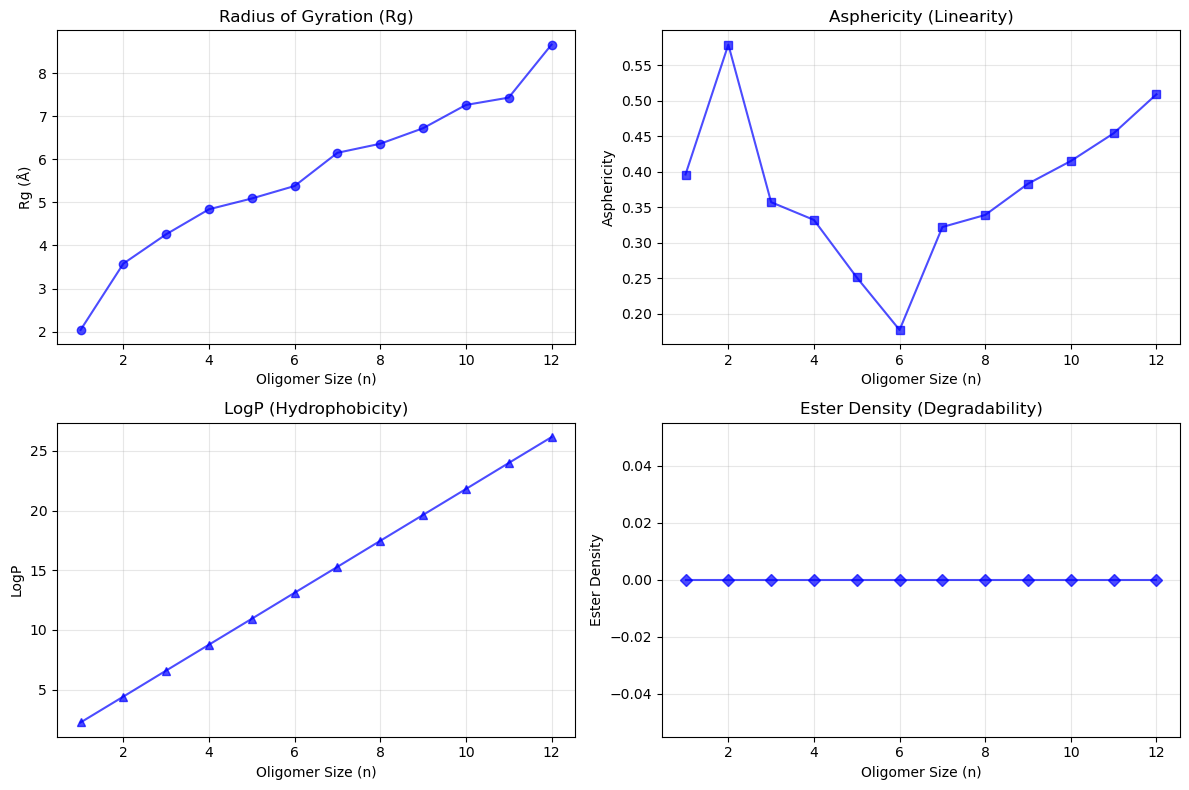

In [12]:
# Plot a single polymer
plot_polymer_scaling(
    polymers_dict,
    polymer_names=["Polystyrene"],
    filename="output/mechanical_prop/polystyrene_mechanical_properties.svg"
)

## **8. Build PHV Oligomers for Comparison (Another PHA)**

In [13]:
print("\nBuilding PHV oligomers...")
phv_smiles = "CC(CC(=O)O)O"  # 3-Hydroxyvaleric acid
phv_rxn = '[C:1](=[O:2])[O:5][H].[C:3][O:4][H:6]>>[C:1](=[O:2])[O:4][C:3].[O:5][H][H:6]'

phv_results = []
for i in range(1, 13):
    mol = build_oligomer(phv_smiles, phv_rxn, i)
    stats = get_comprehensive_stats(mol, i, monomer_length=3.7)
    phv_results.append(stats)
    print(f"\t- Completed {i}-mer")

# Convert information as a DataFrame
phv_df = pd.DataFrame(phv_results)

# Store data in Dictionary
polymers_dict["PHV"] = phv_df

# Print results
print("\nPHV Analysis Complete")
print(phv_df)

# Store DataFrame
phv_df.to_csv('output/mechanical_prop/phv_oligomers.csv', index=False)


Building PHV oligomers...
	- Completed 1-mer
	- Completed 2-mer
	- Completed 3-mer
	- Completed 4-mer
	- Completed 5-mer
	- Completed 6-mer
	- Completed 7-mer
	- Completed 8-mer
	- Completed 9-mer
	- Completed 10-mer
	- Completed 11-mer
	- Completed 12-mer

PHV Analysis Complete
     n       MW  LogP    TPSA  Asphericity     Rg  R_ee  Shape_Ratio  \
0    1   104.10 -0.16   57.53        0.214   1.81  2.39         1.32   
1    2   190.19  0.16   83.83        0.501   2.93  5.30         1.81   
2    3   276.29  0.49  110.13        0.482   3.87  4.65         1.20   
3    4   362.37  0.81  136.43        0.649   5.13  5.27         1.03   
4    5   448.46  1.13  162.73        0.565   5.76  5.14         0.89   
5    6   534.56  1.45  189.03        0.722   7.05  5.32         0.75   
6    7   620.65  1.77  215.33        0.687   8.15  5.92         0.73   
7    8   706.74  2.09  241.63        0.861  10.08  4.72         0.47   
8    9   792.83  2.42  267.93        0.890  11.30  5.11         0.45   

Plot saved to output/mechanical_prop/phv_mechanical_properties.svg


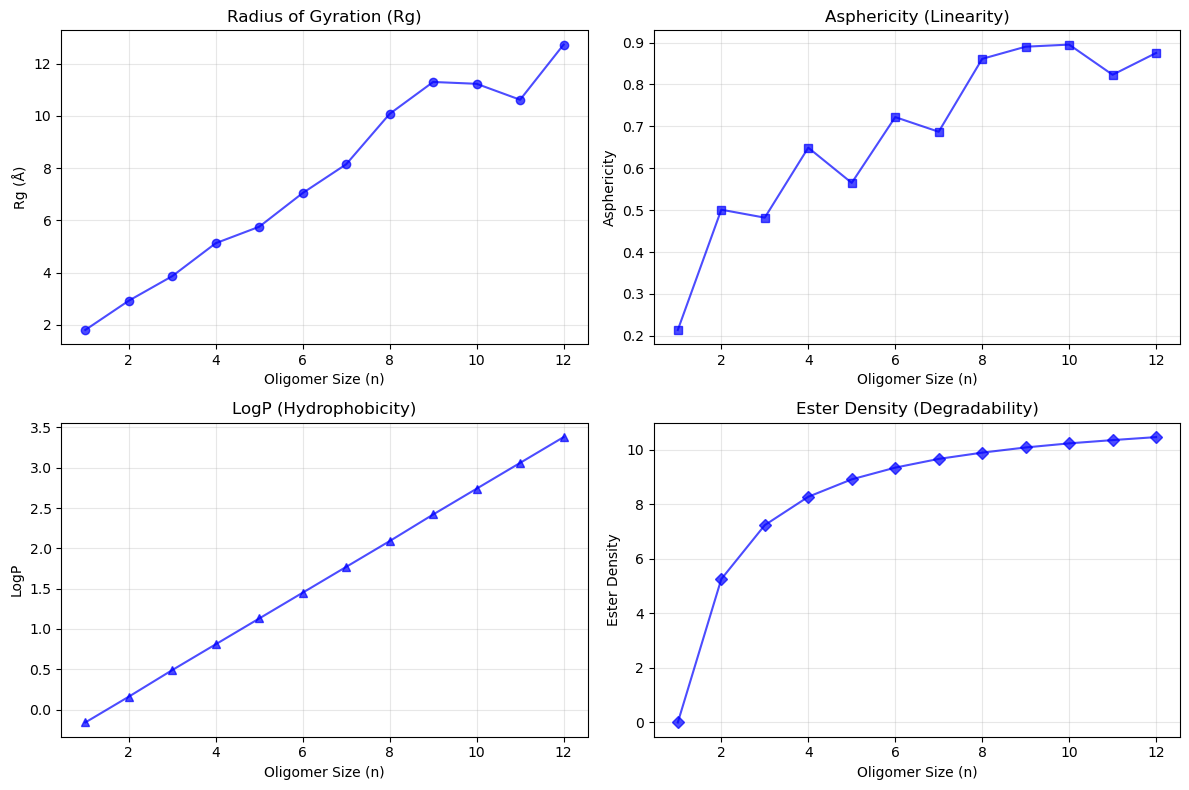

In [14]:
# Plot a single polymer
plot_polymer_scaling(
    polymers_dict,
    polymer_names=["PHV"],
    filename="output/mechanical_prop/phv_mechanical_properties.svg"
)

## **9. Compare Mechanical Properties Across Polymers**

Plot saved to output/comparison_mechanical_properties.svg


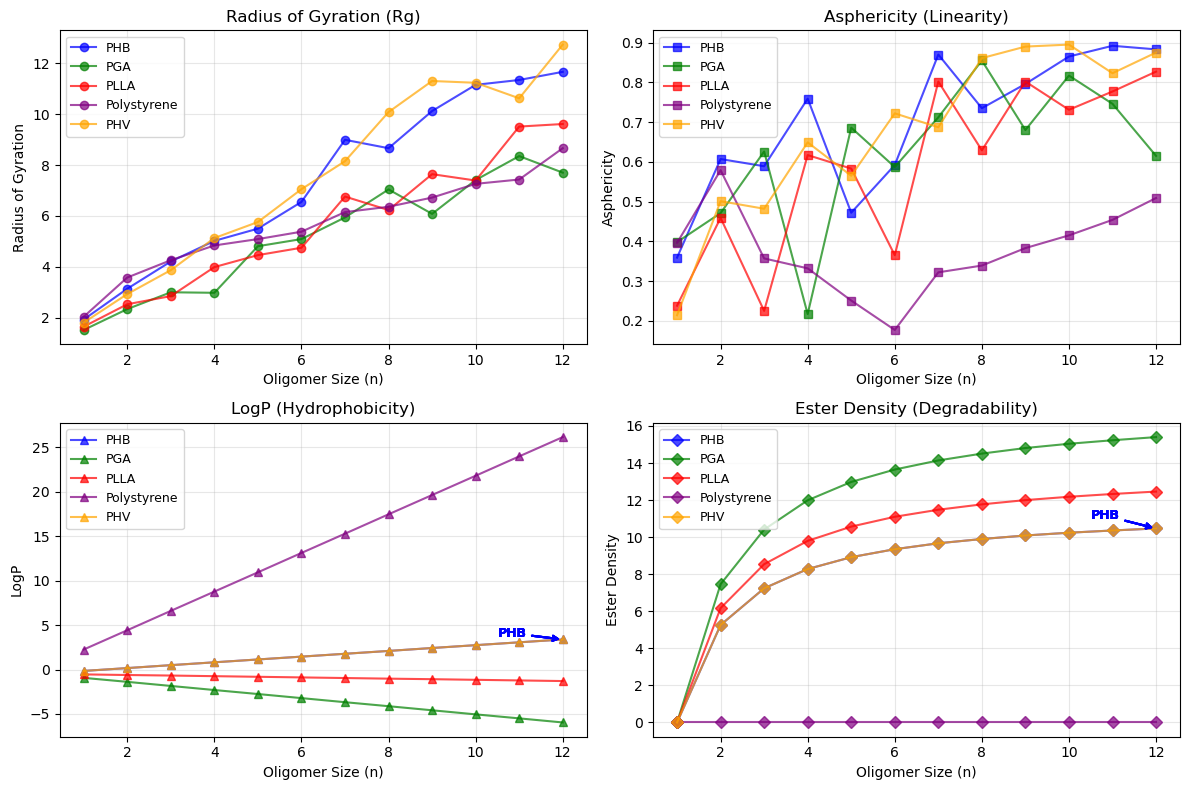

In [15]:
# Plot multiple polymers with PHB annotation
fig, axes = plt.subplots(2, 2, figsize=(12, 8))

# Define colors for different polymers
colors = {'PHB': 'blue', 'PGA': 'green', 'PLLA': 'red', 'Polystyrene': 'purple', 'PHV': 'orange'}
polymer_names = ["PHB", "PGA", "PLLA", "Polystyrene", "PHV"]

for idx, (ax, (title, col_idx)) in enumerate(zip(axes.flat, 
                                                   [("Radius of Gyration (Rg)", 0),
                                                    ("Asphericity (Linearity)", 1),
                                                    ("LogP (Hydrophobicity)", 2),
                                                    ("Ester Density (Degradability)", 3)])):
    for polymer_name in polymer_names:
        df = polymers_dict[polymer_name]
        color = colors[polymer_name]
        
        if col_idx == 0:
            ax.plot(df['n'], df['Rg'], 'o-', color=color, label=polymer_name, alpha=0.7)
        elif col_idx == 1:
            ax.plot(df['n'], df['Asphericity'], 's-', color=color, label=polymer_name, alpha=0.7)
        elif col_idx == 2:
            ax.plot(df['n'], df['LogP'], '^-', color=color, label=polymer_name, alpha=0.7)
            
            # Add annotation for PHB since it's at the top
            phb_logp = phb_df[phb_df['n'] == 12]['LogP'].iloc[0]
            ax.annotate('PHB', xy=(12, phb_logp), xytext=(10.5, phb_logp + 0.3),
                       fontsize=9, color='blue', fontweight='bold',
                       arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
        elif col_idx == 3:
            ax.plot(df['n'], df['Ester_Density'], 'D-', color=color, label=polymer_name, alpha=0.7)
            
            # Add annotation for PHB since it's at the top
            phb_ester = phb_df[phb_df['n'] == 12]['Ester_Density'].iloc[0]
            ax.annotate('PHB', xy=(12, phb_ester), xytext=(10.5, phb_ester + 0.5),
                       fontsize=9, color='blue', fontweight='bold',
                       arrowprops=dict(arrowstyle='->', color='blue', lw=1.5))
    
    ax.set_xlabel('Oligomer Size (n)')
    ax.set_ylabel(title.split('(')[0].strip())
    ax.set_title(title)
    ax.grid(True, alpha=0.3)

# Add legends
for ax in axes.flat:
    ax.legend(loc='best', fontsize=9)

plt.tight_layout()
plt.savefig("output/comparison_mechanical_properties.svg", dpi=300, bbox_inches='tight')
print("Plot saved to output/comparison_mechanical_properties.svg")
plt.show()

## **10. Scaling Law Analysis**

In [16]:
def calculate_scaling_exponent(df):
    """Calculate scaling exponent from Rg vs n data"""
    # --- 1. DATA RETRIEVAL ---
    # We pull 'n' (units) and 'Rg' (Radius of Gyration)
    log_n = np.log(df['n'])
    log_rg = np.log(df['Rg'])

    # --- 2. SCALING LAW REGRESSION ---
    # log(Rg) = log(b) + nu * log(n)
    slope, intercept, r_value, p_value, std_err = linregress(log_n, log_rg)
    nu = slope
    b = np.exp(intercept)

    return {
        'nu': nu,
        'b': b,
        'r_squared': r_value**2,
        'std_error': std_err
    }

# Get scaling exponent from each polymer
phb_scaling = calculate_scaling_exponent(phb_df)
pga_scaling = calculate_scaling_exponent(pga_df)
plla_scaling = calculate_scaling_exponent(plla_df)
phv_scaling = calculate_scaling_exponent(phv_df)
poly_scaling = calculate_scaling_exponent(poly_df)

print("="*70)
print("SCALING LAW ANALYSIS: Rg = b × n^ν")
print("="*70)
print(f"\nPHB:\tν = {phb_scaling['nu']:.3f} (R² = {phb_scaling['r_squared']:.4f})")
print(f"PHV:\tν = {phv_scaling['nu']:.3f} (R² = {phv_scaling['r_squared']:.4f})")
print(f"Polystyrene:\tν = {poly_scaling['nu']:.3f} (R² = {poly_scaling['r_squared']:.4f})")
print(f"PGA:\tν = {pga_scaling['nu']:.3f} (R² = {pga_scaling['r_squared']:.4f})")
print(f"PLLA:\tν = {plla_scaling['nu']:.3f} (R² = {plla_scaling['r_squared']:.4f})")
print("INTERPRETATION:")
print("="*70)
print("ν = 0.5 -> Ideal chain (theta solvent)")
print("ν = 0.6 -> Self-avoiding walk (good solvent)")
print("ν = 1.0 -> Rigid rod")
print("\nHigher ν = more extended/rigid chain structure")

# Rank by flexibility (lower nu = more flexible)
polymers_ranked = [
    ('Polystyrene', poly_scaling['nu']),
    ('PLLA', plla_scaling['nu']),
    ('PGA', pga_scaling['nu']),
    ('PHV', phv_scaling['nu']),
    ('PHB', phb_scaling['nu'])
]
polymers_ranked.sort(key=lambda x: x[1])

print("\n" + "="*70)
print("FLEXIBILITY RANKING ('Most Flexible' to 'Most Rigid'):")
print("="*70)
for rank, (name, nu) in enumerate(polymers_ranked, 1):
    deviation = abs(nu - 0.6) / 0.6 * 100  # % deviation from ideal
    print(f"{rank}. {name:6s} | ν = {nu:.3f} | Deviation from ideal (Good Solvent = 0.6): {deviation:5.1f}%")

SCALING LAW ANALYSIS: Rg = b × n^ν

PHB:	ν = 0.753 (R² = 0.9870)
PHV:	ν = 0.808 (R² = 0.9876)
Polystyrene:	ν = 0.512 (R² = 0.9759)
PGA:	ν = 0.706 (R² = 0.9660)
PLLA:	ν = 0.724 (R² = 0.9713)
INTERPRETATION:
ν = 0.5 -> Ideal chain (theta solvent)
ν = 0.6 -> Self-avoiding walk (good solvent)
ν = 1.0 -> Rigid rod

Higher ν = more extended/rigid chain structure

FLEXIBILITY RANKING ('Most Flexible' to 'Most Rigid'):
1. Polystyrene | ν = 0.512 | Deviation from ideal (Good Solvent = 0.6):  14.6%
2. PGA    | ν = 0.706 | Deviation from ideal (Good Solvent = 0.6):  17.6%
3. PLLA   | ν = 0.724 | Deviation from ideal (Good Solvent = 0.6):  20.6%
4. PHB    | ν = 0.753 | Deviation from ideal (Good Solvent = 0.6):  25.6%
5. PHV    | ν = 0.808 | Deviation from ideal (Good Solvent = 0.6):  34.7%


**Plot scaling exponent of polymers**

Plot saved to output/scaling_law_extrapolation.svg


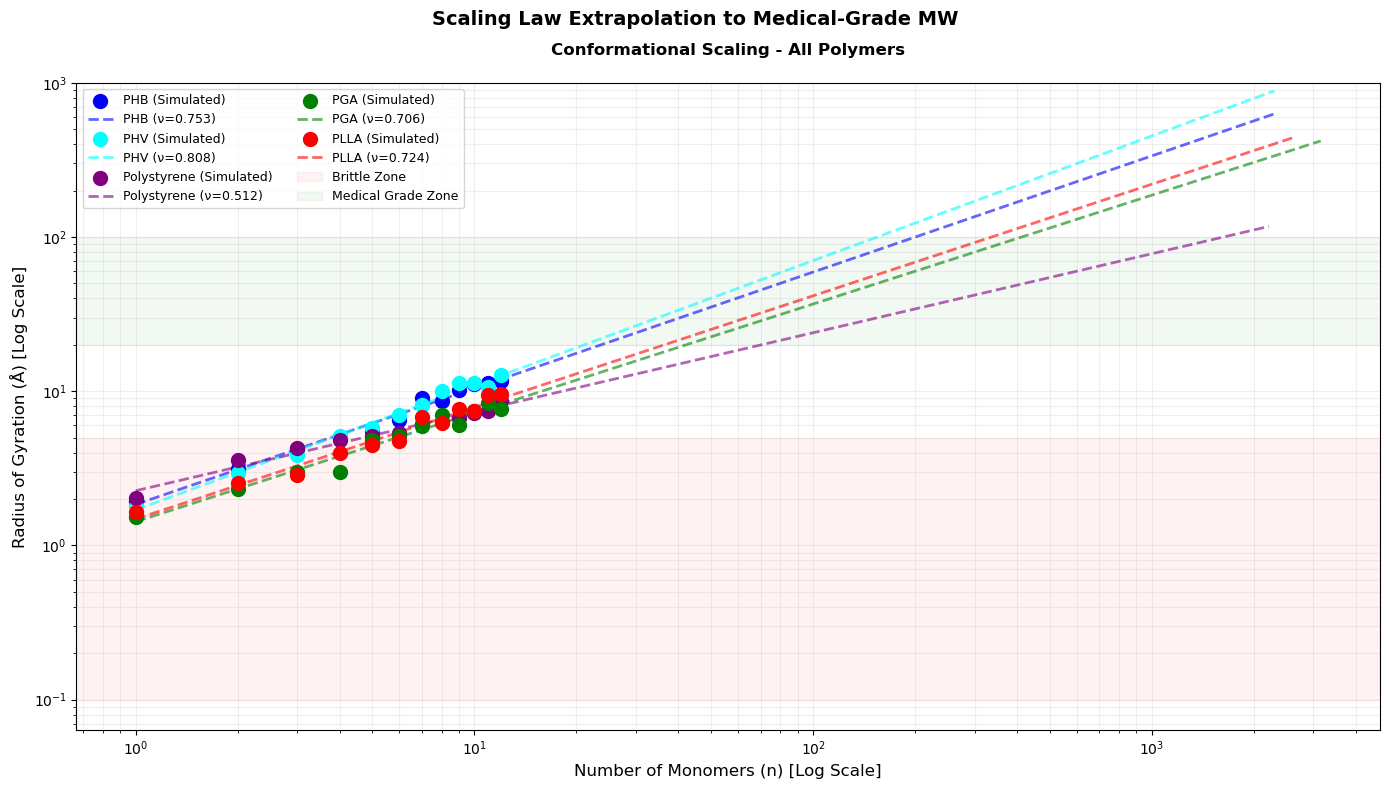

In [17]:
fig, ax = plt.subplots(figsize=(14, 8))
fig.suptitle('Scaling Law Extrapolation to Medical-Grade MW', fontsize=14,
            fontweight='bold')

polymers = [
    ('PHB', phb_df, phb_scaling, phb_df[phb_df["n"] == 1]["MW"].iloc[0], "blue"),
    ('PHV', phv_df, phv_scaling, phv_df[phv_df["n"] == 1]["MW"].iloc[0], "cyan"),
    ('Polystyrene', poly_df, poly_scaling, poly_df[poly_df["n"] == 1]["MW"].iloc[0], "purple"),
    ('PGA', pga_df, pga_scaling, pga_df[pga_df["n"] == 1]["MW"].iloc[0], "green"),
    ('PLLA', plla_df, plla_scaling, plla_df[plla_df["n"] == 1]["MW"].iloc[0], "red")
]

# Effect of Chain Stereoconfiguration on Poly(3-hydroxybutyrate) Crystallization
# Kinetics https://pubs.acs.org/doi/pdf/10.1021/acs.biomac.2c00682
literature_thresholds = {
    "Low MW Brittle Limit": 9000,      # 9 kDa
    "Medical Grade Minimum": 10000,     # 100 kDa
    "High MW Suture Grade": 240000      # 240 kDa
}

for name, df, scaling, mw, color in polymers:
    # Plot actual data
    ax.scatter(df['n'], df['Rg'], color=color, s=100, label=f'{name} (Simulated)',
              zorder=5)
    
    # Extrapolation line
    n_max = literature_thresholds["High MW Suture Grade"] / mw
    n_extrap = np.linspace(1, n_max, 500)
    rg_extrap = scaling['b'] * (n_extrap ** scaling['nu'])
    ax.plot(n_extrap, rg_extrap, '--', color=color, alpha=0.6, linewidth=2,
           label=f'{name} (ν={scaling["nu"]:.3f})')

# Medical zones (shaded in background) - using fixed y-axis range
ax.axhspan(0.1, 5, color='red', alpha=0.05, label='Brittle Zone')
ax.axhspan(20, 100, color='green', alpha=0.05, label='Medical Grade Zone')

ax.set_xscale('log')
ax.set_yscale('log')

# Set y-axis limits to start from a reasonable minimum
ax.set_ylim(0.0, 1000)

ax.set_title('Conformational Scaling - All Polymers', fontweight='bold', pad=20)
ax.set_xlabel('Number of Monomers (n) [Log Scale]', fontsize=12)
ax.set_ylabel('Radius of Gyration (Å) [Log Scale]', fontsize=12)
ax.legend(loc='upper left', fontsize=9, ncol=2)
ax.grid(True, which="both", ls="-", alpha=0.2)

plt.tight_layout()
plt.savefig("output/scaling_law_extrapolation.svg", dpi=300, bbox_inches='tight')
print("Plot saved to output/scaling_law_extrapolation.svg")
plt.show()

**Print miminum of monomers for medical grade**

In [18]:
print("MINIMUM MONOMERS TO REACH MEDICAL GRADE (100 kDa)")
print("="*60)

# Assuming literature_thresholds["Medical Grade Minimum"] is in kDa:
medical_grade_kDa = literature_thresholds["Medical Grade Minimum"]  # e.g., 100 kDa
medical_grade_g_per_mol = medical_grade_kDa * 1000  # Convert to g/mol

for name, df, scaling, mw, color in polymers:
    # Calculate n needed to reach medical grade MW (g/mol)
    n_medical = medical_grade_g_per_mol / mw
    
    # Calculate Rg at medical grade
    rg_medical = scaling['b'] * (n_medical ** scaling['nu'])
    
    # Find actual MW at this n
    actual_mw_g_per_mol = mw * n_medical
    actual_mw_kDa = actual_mw_g_per_mol / 1000
    
    print(f"\n{name}:")
    print(f"\t- Monomer MW: {mw:.2f} g/mol")
    print(f"\t- Monomers needed: {n_medical:.1f}")
    print(f"\t- Predicted MW: {actual_mw_g_per_mol:.0f} g/mol ({actual_mw_kDa:.1f} kDa)")
    print(f"\t- Predicted Rg: {rg_medical:.2f} Å")

MINIMUM MONOMERS TO REACH MEDICAL GRADE (100 kDa)

PHB:
	- Monomer MW: 104.10 g/mol
	- Monomers needed: 96061.5
	- Predicted MW: 10000000 g/mol (10000.0 kDa)
	- Predicted Rg: 10452.37 Å

PHV:
	- Monomer MW: 104.10 g/mol
	- Monomers needed: 96061.5
	- Predicted MW: 10000000 g/mol (10000.0 kDa)
	- Predicted Rg: 18084.54 Å

Polystyrene:
	- Monomer MW: 108.18 g/mol
	- Monomers needed: 92438.5
	- Predicted MW: 10000000 g/mol (10000.0 kDa)
	- Predicted Rg: 791.17 Å

PGA:
	- Monomer MW: 76.05 g/mol
	- Monomers needed: 131492.4
	- Predicted MW: 10000000 g/mol (10000.0 kDa)
	- Predicted Rg: 5833.82 Å

PLLA:
	- Monomer MW: 90.08 g/mol
	- Monomers needed: 111012.4
	- Predicted MW: 10000000 g/mol (10000.0 kDa)
	- Predicted Rg: 6636.83 Å


## END